In [121]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost as xgb
from sklearn import svm
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
)

In [122]:
sex= 'Female'
control = pd.read_csv(f"../result/Control_{sex}.csv")
training = pd.read_csv(f"../result/Training_{sex}.csv")

print(control.shape)
print(training.shape)

(4588, 166)
(2099, 166)


In [123]:
features = pd.concat([control,training],ignore_index=True)
features = features.drop(columns=['TWB2_ID','I_32','Label'])

#將ID排除
X = features.iloc[:,1::]
print(X.info())

feature_names = X.columns
X = [X.iloc[i,:].values.flatten().tolist() for i in range(control.shape[0]+training.shape[0])]
print('樣本數: ',len(X))

control_label=control.iloc[:,-1]
training_label=training.iloc[:,-1]
y=pd.concat([control_label,training_label],ignore_index=True)
label_encoder = LabelEncoder()
y = list(label_encoder.fit_transform(y))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6687 entries, 0 to 6686
Columns: 162 entries, AGE to MICROALB
dtypes: float64(162)
memory usage: 8.3 MB
None
樣本數:  6687


In [124]:
from collections import Counter

# 分割資料集 (training and validation sets)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"訓練集樣本數量： {len(X_train)}")
print(f"測試集樣本數量： {len(X_val)}")
train_class_distribution = Counter(y_train)
val_class_distribution = Counter(y_val)
print("訓練集中各類別樣本數量：")
print(train_class_distribution)
print("測試集中各類別樣本數量：")
print(val_class_distribution)

訓練集樣本數量： 6018
測試集樣本數量： 669
訓練集中各類別樣本數量：
Counter({0: 4124, 1: 1894})
測試集中各類別樣本數量：
Counter({0: 464, 1: 205})


In [125]:
# SMOTE
# train set use SMOTE
smote_train_X, smote_train_Y = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("SMOTE train set sampling:")
print(Counter(smote_train_Y))

# train set use BSMOTE
bsmote_train_X, bsmote_train_Y = BorderlineSMOTE(
    random_state=42, kind="borderline-2"
).fit_resample(X_train, y_train)
print("BSMOTE train set sampling:")
print(Counter(bsmote_train_Y))

# test set balance
bal_x_test, bal_y_test = RandomUnderSampler(random_state=42).fit_resample(X_val, y_val)
print("Random sampling:")
print(Counter(bal_y_test))

smote_test_X, smote_test_Y = SMOTE(random_state=42).fit_resample(X_val, y_val)
print("SMOTE test set sampling:")
print(Counter(smote_test_Y))

bsmote_test_X, bsmote_test_Y = BorderlineSMOTE(random_state=42).fit_resample(X_val, y_val)
print("BSMOTE test set sampling:")
print(Counter(bsmote_test_Y))

SMOTE train set sampling:
Counter({1: 4124, 0: 4124})
BSMOTE train set sampling:
Counter({1: 4124, 0: 4124})
Random sampling:
Counter({0: 205, 1: 205})
SMOTE test set sampling:
Counter({0: 464, 1: 464})
BSMOTE test set sampling:
Counter({0: 464, 1: 464})


In [126]:
# Male
# selected_features = ['I_18', 'I_11', 'I_23', 'ANTI_HBC_AB_1', 'EYE_DIS', 'NECK_ACHE',
#                      'BACK_AND_WAIST_ACHE', 'CARCINOMA_IN_SITU', 'DIABETES', 'GOUT']
# Female
selected_features = ['I_16', 'I_22', 'I_11', 'ORTHOPEDICS_ARTICULUS', 'EYE_DIS', 'I_18',
                    'ARTICULUS_ACHE', 'MENSTRURATION_CURR', 'I_33', 'I_24', 'SPO_HABIT',
                    'DIABETES', 'I_35', 'I_26', 'MC_DURATION', 'I_37', 'I_9', 'AGE', 'I_31',
                    'CARCINOMA_IN_SITU']

indices = [feature_names.get_loc(feature) for feature in selected_features]
print("feature num:", len(indices))

smote_train_X = [[row[i] for i in indices] for row in smote_train_X]
smote_test_X = [[row[i] for i in indices] for row in smote_test_X]
bsmote_test_X = [[row[i] for i in indices] for row in bsmote_test_X]

feature num: 20


In [127]:
def plot_confusion_matrix(confusion):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True])
    cm_display.plot()
    plt.show()

def evalution_metrics(test_label, labels_score, txt_name, save=True, path="../result/"):
    accuracy = accuracy_score(test_label, labels_score.round())
    confusion = confusion_matrix(test_label, labels_score.round())

    # plot confusion matrix
    plot_confusion_matrix(confusion)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    precision = TP / float(TP + FP)
    sensitivity = TP / float(FN + TP)
    specificity = TN / float(TN + FP)
    f1 = f1_score(test_label, labels_score.round())
    mcc = matthews_corrcoef(test_label, labels_score.round())

    metrics = np.round([TP, TN, FP, FN, accuracy, precision, sensitivity, specificity, f1, mcc], 2)
    columns = ["TP","TN","FP","FN","accuracy","precision","sensitivity","specificity","f1","mcc",]
    metrics_dict = dict(zip(columns, metrics))

    if save:
        df = pd.DataFrame(metrics_dict, index=[0])
        df.to_csv(path + "%s_metrics.csv" % txt_name)

        print("  # TP: %f" % TP + "\n")
        print("  # TN: %f" % TN + "\n")
        print("  # FP: %f" % FP + "\n")
        print("  # FN: %f" % FN + "\n")
        print("  # Accuracy: %f" % accuracy + "\n")
        print("  # Precision: %f" % precision + "\n")
        print("  # Sensitivity/Recall: %f" % sensitivity + "\n")
        print("  # Specificity: %f" % specificity + "\n")
        print("  # F1 score: %f" % f1 + "\n")
        print("  # Matthews Corrcoef:%f" % mcc + "\n")
    else:
        return metrics_dict

In [128]:
X_train = np.array(smote_train_X)
y_train = np.array(smote_train_Y)

print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape)

print("y_train type:", type(y_train))
print("y_train shape:", y_train.shape)

X_val = np.array(smote_test_X)
y_val = np.array(smote_test_Y)

X_train type: <class 'numpy.ndarray'>
X_train shape: (8248, 20)
y_train type: <class 'numpy.ndarray'>
y_train shape: (8248,)


#### CNN

In [129]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPool1D, Dense, Dropout, Add
#from tensorflow.keras.layers import Embedding, Masking
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

cnn_model = Sequential()
cnn_model.add(Input(shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(32, 10, activation='relu', padding="same",kernel_regularizer=regularizers.l2(0.0001))) # Female
# cnn_model.add(Conv1D(32, 10, activation='relu', padding="same",kernel_regularizer=regularizers.l2(0.000001))) # Male
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3)) # Female
# cnn_model.add(Dropout(0.4)) # Male
cnn_model.add(Flatten())

cnn_model.add(Dense(1, activation = "sigmoid"))
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy'])

#saveBestModel = tensorflow.keras.callbacks.ModelCheckpoint(filepath=best_model, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#CSVLogger = tensorflow.keras.callbacks.CSVLogger("cnn_csvLogger.csv" ,separator=',', append=False)
#e_s = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=150,verbose=0, mode='min')

# Male epochs=2000, batch_size=2048
# Female epochs=500, batch_size=256
cnn_t_m = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=500, batch_size=256)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5482 - loss: 0.8135 - val_accuracy: 0.5280 - val_loss: 0.9888
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6316 - loss: 0.6804 - val_accuracy: 0.5162 - val_loss: 0.9149
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6468 - loss: 0.6533 - val_accuracy: 0.6196 - val_loss: 0.7389
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6647 - loss: 0.6341 - val_accuracy: 0.6692 - val_loss: 0.6682
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6693 - loss: 0.6305 - val_accuracy: 0.6638 - val_loss: 0.6630
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6794 - loss: 0.6140 - val_accuracy: 0.7317 - val_loss: 0.5814
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6727 - loss: 0.6136 - val_accuracy: 0.7220 - val_loss: 0.5780
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6911 - loss: 0.5984 - val_accuracy: 0.7263 - v

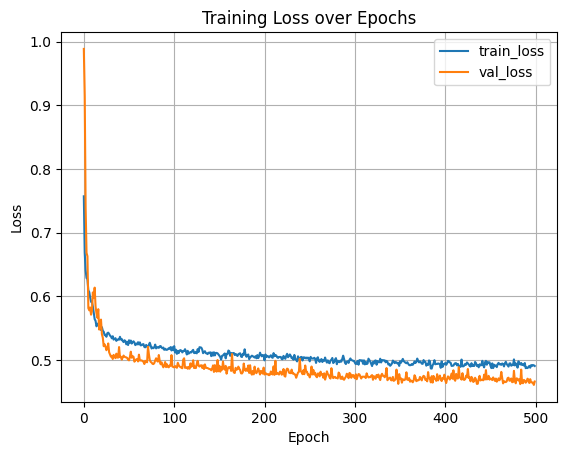

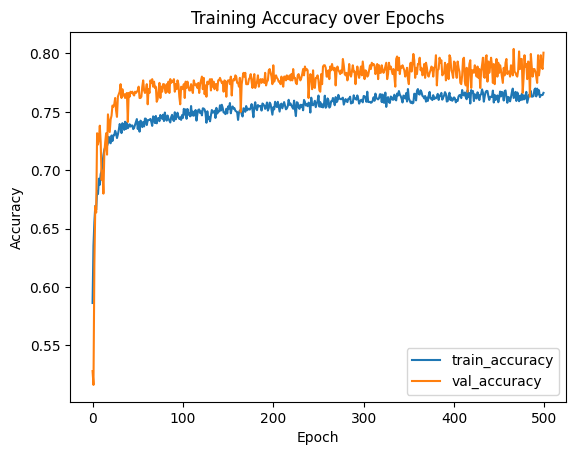

In [130]:
plt.plot(cnn_t_m.history["loss"], label="train_loss")
plt.plot(cnn_t_m.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(cnn_t_m.history["accuracy"], label="train_accuracy")
plt.plot(cnn_t_m.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend(loc="lower right")
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step


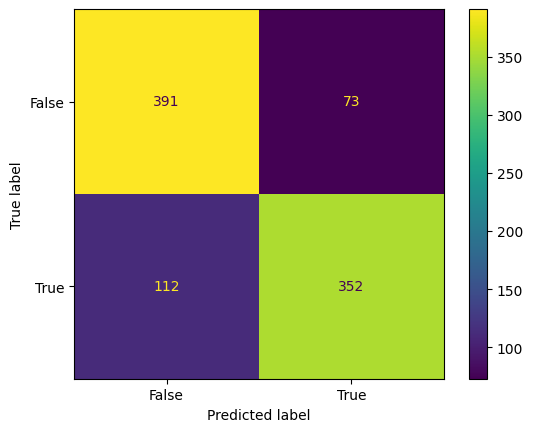

  # TP: 352.000000

  # TN: 391.000000

  # FP: 73.000000

  # FN: 112.000000

  # Accuracy: 0.800647

  # Precision: 0.828235

  # Sensitivity/Recall: 0.758621

  # Specificity: 0.842672

  # F1 score: 0.791901

  # Matthews Corrcoef:0.603428



In [131]:
# CNN prediction
cnn_score = cnn_model.predict(X_val)
cnn_res = evalution_metrics(y_val, cnn_score,'cnn')

#### LSTM

In [135]:
#LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=10, return_sequences=True))
lstm_model.add(Dropout(0.3)) # Male dropout=0.4、Female dropout=0.3
# lstm_model.add(LSTM(units = 10))
# lstm_model.add(Dropout(0.1))
lstm_model.add(Flatten())

# lstm_model.add(BatchNormalization())
lstm_model.add(Dense(units = 1, kernel_regularizer=l2(0.0001)))
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])

# Male epochs=1000, batch_size=256 
# Female epochs=600, batch_size=256
lstm_t_m = lstm_model.fit(X_train, y_train, epochs = 600, batch_size = 256,validation_data=(X_val, y_val),verbose=1)

Epoch 1/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5149 - loss: 0.9655 - val_accuracy: 0.5776 - val_loss: 0.2438
Epoch 2/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5583 - loss: 0.2991 - val_accuracy: 0.6756 - val_loss: 0.2153
Epoch 3/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5926 - loss: 0.2626 - val_accuracy: 0.7263 - val_loss: 0.2046
Epoch 4/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6156 - loss: 0.2486 - val_accuracy: 0.7403 - val_loss: 0.1965
Epoch 5/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6332 - loss: 0.2381 - val_accuracy: 0.7457 - val_loss: 0.1889
Epoch 6/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6578 - loss: 0.2234 - val_accuracy: 0.7435 - val_loss: 0.1820
Epoch 7/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6746 - loss: 0.2167 - val_accuracy: 0.7500 - val_loss: 0.1764
Epoch 8/600
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6770 - loss: 0.2108 - val_accuracy: 0.7522 - 

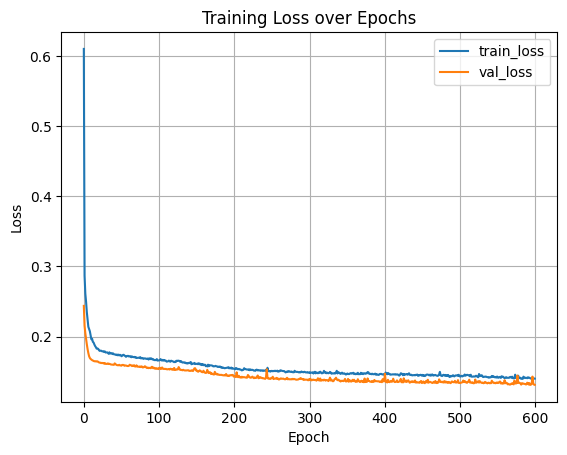

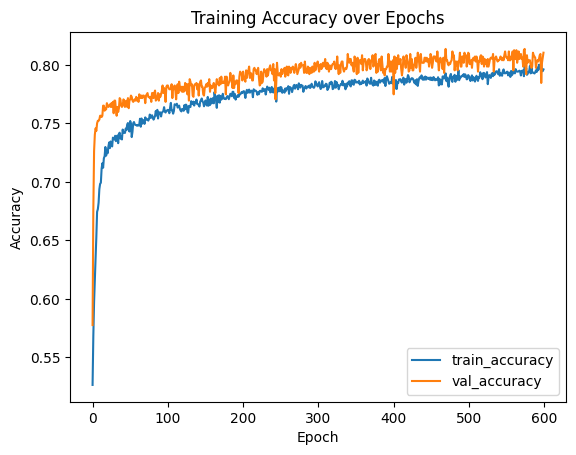

In [136]:
plt.plot(lstm_t_m.history["loss"], label="train_loss")
plt.plot(lstm_t_m.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(lstm_t_m.history["accuracy"], label="train_accuracy")
plt.plot(lstm_t_m.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend(loc="lower right")
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


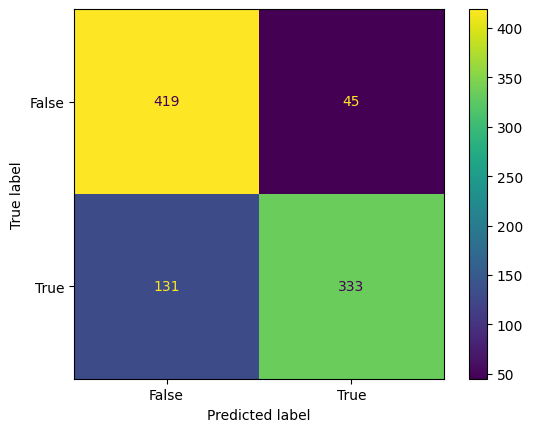

  # TP: 333.000000

  # TN: 419.000000

  # FP: 45.000000

  # FN: 131.000000

  # Accuracy: 0.810345

  # Precision: 0.880952

  # Sensitivity/Recall: 0.717672

  # Specificity: 0.903017

  # F1 score: 0.790974

  # Matthews Corrcoef:0.631634



In [137]:
# LSTM prediction
lstm_score = lstm_model.predict(X_val)
lstm_res = evalution_metrics(y_val, lstm_score,'lstm')